<a href="https://colab.research.google.com/github/kadirov1194/Power_Forecasting/blob/main/Hourly_energy_demand_generation_and_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Purpose of this Notebook
This notebook is preapared for time series prediction practice by using Hourly energy demand generation and weather datasets.
In this notebook, The Energy demand dataset divided to train data and test data. 2015 to 2017 data is used train data and make prediction model by LightGBM and reviewed the model performance by 2018 test data.

Please utilize this code as a reference for learning time series data prediction and training competition.

## Import Libralies


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install --upgrade category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#data analysis libraries
import numpy as np
import pandas as pd
import math
pd.set_option('display.max_columns', 50)

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#machinelearning libraries
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import lightgbm as lgb
import category_encoders as ce
from sklearn.decomposition import PCA
import tqdm
from sklearn import preprocessing

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/forecasting'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.resetwarnings()
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', DeprecationWarning)

/content/drive/MyDrive/forecasting/energy_dataset.csv
/content/drive/MyDrive/forecasting/weather_features.csv
/content/drive/MyDrive/forecasting/Hourly energy demand generation and weather.ipynb


## Make Train/Test Data

In [ ]:
#Import Original data
df_energy=pd.read_csv("/content/drive/MyDrive/forecasting/energy_dataset.csv")
df_weather=pd.read_csv("/content/drive/MyDrive/forecasting/weather_features.csv")

In [ ]:
# Confirm Dataset years
df_energy=df_energy[~df_energy["price actual"].isnull()]
df_energy.time=pd.to_datetime(df_energy.time)
df_weather.dt_iso=pd.to_datetime(df_weather.dt_iso)

df_energy["year"]=df_energy.time.apply(lambda x: x.year)
df_weather["year"]=df_weather.dt_iso.apply(lambda x: x.year)
display(df_energy.year.unique())
display(df_weather.year.unique())

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


array([2015, 2016, 2017, 2018])

array([2015, 2016, 2017, 2018])

In [ ]:
df_energy.groupby("year")["price actual"].count()

year
2015    8760
2016    8784
2017    8760
2018    8760
Name: price actual, dtype: int64

In [ ]:
df_weather.groupby("year")["dt_iso"].count()

year
2015    44070
2016    44596
2017    44647
2018    45083
Name: dt_iso, dtype: int64

In [ ]:
train = df_energy[df_energy.year!=2018].reset_index(drop=True)
ids=train.index
train.insert(0,"id",ids)
train=train.drop(columns=["year"])

In [ ]:
test = df_energy[df_energy.year==2018].reset_index(drop=True)
ids=test.index
test_price=test["price actual"]
test.insert(0,"id",ids)
test=test.drop(columns=["price actual","year"])

In [ ]:
test

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen imp

,id,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead
0,0,2018-01-01 00:00:00+01:00,282.0,0.0,0.0,3471.0,996.0,194.0,0.0,0.0,0.0,NaN,2094.0,1076.0,1162.0,0.0,7057.0,52.0,79.0,9.0,237.0,0.0,12348.0,6.0,NaN,12879.0,23324.0,22779.0,6.74
1,1,2018-01-01 01:00:00+01:00,275.0,0.0,0.0,3269.0,959.0,191.0,0.0,0.0,0.0,NaN,2115.0,1046.0,799.0,0.0,7057.0,51.0,77.0,9.0,238.0,0.0,11156.0,0.0,NaN,11527.0,22688.0,22009.0,4.74
2,2,2018-01-01 02:00:00+01:00,278.0,0.0,0.0,3541.0,1014.0,191.0,0.0,0.0,0.0,NaN,2037.0,1048.0,898.0,0.0,7058.0,51.0,79.0,9.0,236.0,0.0,9437.0,1.0,NaN,10749.0,21521.0,20589.0,3.66
3,3,2018-01-01 03:00:00+01:00,278.0,0.0,0.0,3450.0,1043.0,191.0,0.0,0.0,0.0,NaN,2126.0,1021.0,714.0,0.0,7061.0,52.0,79.0,9.0,238.0,0.0,6474.0,4.0,NaN,8095.0,20294.0,19547.0,2.30
4,4,2018-01-01 04:00:00+01:00,279.0,0.0,0.0,3318.0,1063.0,191.0,0.0,0.0,0.0,NaN,2580.0,1033.0,661.0,0.0,7066.0,51.0,79.0,9.0,239.0,0.0,6329.0,6.0,NaN,6391.0,19489.0,18871.0,2.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8755,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,NaN,1.0,1135.0,4836.0,0.0,6073.0,63.0,95.0,85.0,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85
8756,8756,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,NaN,1.0,1172.0,3931.0,0.0,6074.0,62.0,95.0,33.0,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40
8757,8757,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,NaN,50.0,1148.0,2831.0,0.0,6076.0,61.0,94.0,31.0,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88
8758,8758,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,NaN,108.0,1128.0,2068.0,0.0,6075.0,61.0,93.0,31.0,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93


In [ ]:
sub_df=pd.DataFrame(columns=["id","predicted"])
sub_df.id=test.index

##2.Data Confirmation & Pre-Treatment

In [ ]:
#Train_Dataset
display(train.head())
display(train.shape)

#Test_Dataset
display(test.head())
display(test.shape)

#Weather_Dataset
display(df_weather.head())
display(df_weather.shape)

,id,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


(26304, 30)

,id,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead
0,0,2018-01-01 00:00:00+01:00,282.0,0.0,0.0,3471.0,996.0,194.0,0.0,0.0,0.0,NaN,2094.0,1076.0,1162.0,0.0,7057.0,52.0,79.0,9.0,237.0,0.0,12348.0,6.0,NaN,12879.0,23324.0,22779.0,6.74
1,1,2018-01-01 01:00:00+01:00,275.0,0.0,0.0,3269.0,959.0,191.0,0.0,0.0,0.0,NaN,2115.0,1046.0,799.0,0.0,7057.0,51.0,77.0,9.0,238.0,0.0,11156.0,0.0,NaN,11527.0,22688.0,22009.0,4.74
2,2,2018-01-01 02:00:00+01:00,278.0,0.0,0.0,3541.0,1014.0,191.0,0.0,0.0,0.0,NaN,2037.0,1048.0,898.0,0.0,7058.0,51.0,79.0,9.0,236.0,0.0,9437.0,1.0,NaN,10749.0,21521.0,20589.0,3.66
3,3,2018-01-01 03:00:00+01:00,278.0,0.0,0.0,3450.0,1043.0,191.0,0.0,0.0,0.0,NaN,2126.0,1021.0,714.0,0.0,7061.0,52.0,79.0,9.0,238.0,0.0,6474.0,4.0,NaN,8095.0,20294.0,19547.0,2.30
4,4,2018-01-01 04:00:00+01:00,279.0,0.0,0.0,3318.0,1063.0,191.0,0.0,0.0,0.0,NaN,2580.0,1033.0,661.0,0.0,7066.0,51.0,79.0,9.0,239.0,0.0,6329.0,6.0,NaN,6391.0,19489.0,18871.0,2.30


(8760, 29)

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon,year
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n,2015
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n,2015
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n,2015
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n,2015
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n,2015


(178396, 18)

###2.1 Energy Dataset

In [ ]:
#Confirm data summary
train.describe(include="all")

,id,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,26304.000000,26304,26286.000000,26287.000000,26287.0,26287.000000,26287.000000,26286.000000,26287.0,26287.0,26287.0,0.0,26286.000000,26286.000000,26287.000000,26286.0,26288.000000,26287.000000,26287.000000,26287.000000,26286.000000,26287.0,26287.000000,26304.000000,0.0,26304.000000,26304.000000,26270.000000,26304.000000,26304.000000
unique,NaN,26304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2015-01-01 00:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,13151.500000,NaN,399.042989,479.779815,0.0,5557.593449,4443.860996,303.688085,0.0,0.0,0.0,NaN,505.863920,888.344252,2506.489025,0.0,6324.476605,62.493057,81.556511,1452.636665,259.694780,0.0,5424.466048,1453.701376,NaN,5426.090062,28593.576718,28574.698135,47.403393,56.033923
std,7593.455077,NaN,89.930991,365.462355,0.0,2271.946675,2029.961420,54.135315,0.0,0.0,0.0,NaN,806.210932,369.377771,1868.701928,0.0,827.861781,21.443989,13.344572,1686.924461,51.273487,0.0,3180.779919,1685.793772,NaN,3170.254373,4575.987877,4550.920544,14.348612,14.336757
min,0.000000,NaN,0.000000,0.000000,0.0,1518.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18164.000000,18041.000000,2.300000,9.330000
25%,6575.750000,NaN,341.000000,0.000000,0.0,4069.000000,2619.000000,268.000000,0.0,0.0,0.0,NaN,0.000000,595.000000,954.500000,0.0,5900.000000,53.000000,71.000000,77.000000,225.000000,0.0,2941.000000,69.000000,NaN,2949.000000,24677.000000,24695.250000,39.640000,47.630000
50%,13151.500000,NaN,378.000000,564.000000,0.0,4864.000000,4761.000000,303.000000,0.0,0.0,0.0,NaN,90.000000,796.000000,1990.000000,0.0,6735.500000,58.000000,81.000000,629.000000,267.000000,0.0,4815.000000,588.000000,NaN,4821.000000,28824.500000,28817.500000,48.040000,55.940000
75%,19727.250000,NaN,480.000000,863.000000,0.0,6260.500000,6106.000000,336.000000,0.0,0.0,0.0,NaN,700.000000,1148.000000,3663.000000,0.0,7072.000000,84.000000,92.000000,2631.500000,300.000000,0.0,7307.000000,2672.000000,NaN,7292.000000,32079.250000,32010.750000,56.610000,65.192500


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 30 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   id                                           26304 non-null  int64  
 1   time                                         26304 non-null  object 
 2   generation biomass                           26286 non-null  float64
 3   generation fossil brown coal/lignite         26287 non-null  float64
 4   generation fossil coal-derived gas           26287 non-null  float64
 5   generation fossil gas                        26287 non-null  float64
 6   generation fossil hard coal                  26287 non-null  float64
 7   generation fossil oil                        26286 non-null  float64
 8   generation fossil oil shale                  26287 non-null  float64
 9   generation fossil peat                       26287 non-null  float64
 10

In [ ]:
# Drop unusable columns like NaN,0
# forecast data also dropped to pridict with actual data only

drop_columns=['id',
            'generation fossil coal-derived gas',
            'generation fossil oil shale', 
            'generation fossil peat',
            'generation geothermal', 
            'generation hydro pumped storage aggregated', 
            'generation marine', 
            'generation wind offshore',
            'forecast wind offshore eday ahead',
            'total load forecast',
            'forecast solar day ahead',
            'forecast wind onshore day ahead']


train = train.drop(drop_columns, axis=1)
test = test.drop(drop_columns, axis=1)

In [ ]:
#Confirm null data rate
def get_null_df(df: pd.DataFrame):
    """Calculate missing data rate

    Args:
        df (pd.DataFrame): target_df

    Returns:
        col_null_df: dataframe of null_feature_rate
    """
    col_null_df = pd.DataFrame(columns = ['Column', 'Type', 'Total NaN', '%'])
    col_null = df.columns[df.isna().any()].to_list()
    L = len(df)
    for col in col_null:
        T = 0
        if df[col].dtype == "float64":
            T = "Numerical"  
        elif df[col].dtype == "int64":
            T = "Numerical"  
        else:
            T = "Categorical"
        nulls = len(df[df[col].isna() == True][col])   
        col_null_df = col_null_df.append({'Column': col, 
                                        'Type': T,
                                        'Total NaN': nulls,
                                        '%': (nulls / L)*100
                                        }, ignore_index=True)
    return col_null_df

print("Train_data")
display(get_null_df(train))


print("Test_data")
display(get_null_df(test))

Train_data


,Column,Type,Total NaN,%
0,generation biomass,Numerical,18,0.068431
1,generation fossil brown coal/lignite,Numerical,17,0.064629
2,generation fossil gas,Numerical,17,0.064629
3,generation fossil hard coal,Numerical,17,0.064629
4,generation fossil oil,Numerical,18,0.068431
5,generation hydro pumped storage consumption,Numerical,18,0.068431
6,generation hydro run-of-river and poundage,Numerical,18,0.068431
7,generation hydro water reservoir,Numerical,17,0.064629
8,generation nuclear,Numerical,16,0.060827
9,generation other,Numerical,17,0.064629


Test_data


,Column,Type,Total NaN,%
0,generation biomass,Numerical,1,0.011416
1,generation fossil brown coal/lignite,Numerical,1,0.011416
2,generation fossil gas,Numerical,1,0.011416
3,generation fossil hard coal,Numerical,1,0.011416
4,generation fossil oil,Numerical,1,0.011416
5,generation hydro pumped storage consumption,Numerical,1,0.011416
6,generation hydro run-of-river and poundage,Numerical,1,0.011416
7,generation hydro water reservoir,Numerical,1,0.011416
8,generation nuclear,Numerical,1,0.011416
9,generation other,Numerical,1,0.011416


In [ ]:
#Fill NaN values with ffill
time_train=train["time"]
time_test=test["time"]

train=train.iloc[:,2:].interpolate(method='linear', limit_direction='forward', axis=0)
test=test.iloc[:,2:].interpolate(method='linear', limit_direction='forward', axis=0)

train.insert(0,"time",time_train)
test.insert(0,"time",time_test)

## Weather Data

In [ ]:
#Confirm data summary
df_weather.describe(include="all")

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon,year
count,178396,178396,178396.000000,178396.000000,178396.000000,1.783960e+05,178396.000000,178396.00000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000,178396,178396,178396,178396.000000
unique,35064,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,43,24,NaN
top,2015-10-01 02:00:00+02:00,Madrid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,clear,sky is clear,01n,NaN
freq,10,36267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82685,82685,38541,NaN
mean,NaN,NaN,289.618605,288.330442,291.091267,1.069261e+03,68.423457,2.47056,166.591190,0.075492,0.000380,0.004763,25.073292,759.831902,NaN,NaN,NaN,2016.508661
std,NaN,NaN,8.026199,7.955491,8.612454,5.969632e+03,21.902888,2.09591,116.611927,0.398847,0.007288,0.222604,30.774129,108.733223,NaN,NaN,NaN,1.117778
min,NaN,NaN,262.240000,262.240000,262.240000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000,NaN,NaN,NaN,2015.000000
25%,NaN,NaN,283.670000,282.483602,284.650000,1.013000e+03,53.000000,1.00000,55.000000,0.000000,0.000000,0.000000,0.000000,800.000000,NaN,NaN,NaN,2016.000000
50%,NaN,NaN,289.150000,288.150000,290.150000,1.018000e+03,72.000000,2.00000,177.000000,0.000000,0.000000,0.000000,20.000000,800.000000,NaN,NaN,NaN,2017.000000
75%,NaN,NaN,295.150000,293.730125,297.150000,1.022000e+03,87.000000,4.00000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000,NaN,NaN,NaN,2018.000000


In [ ]:
def get_unique_df(df: pd.DataFrame):
    """Show unique column data

    Args:
        df (pd.dataFrame):target_df 

    Returns:
        unique_df: unique_df_columns
    """
    unique_df = pd.DataFrame(columns=['Feature', 'Unique', 'Count'])
    for col in df.columns:
        v = df[col].unique()
        l = len(v)
        unique_df = unique_df.append({'Feature':col, 
                                    'Unique':v,
                                    'Count':l}, ignore_index=True)
    return unique_df

get_unique_df(df_weather)

,Feature,Unique,Count
0,dt_iso,"[2015-01-01 00:00:00+01:00, 2015-01-01 01:00:0...",35064
1,city_name,"[Valencia, Madrid, Bilbao, Barcelona, Seville]",5
2,temp,"[270.475, 269.686, 270.29200000000003, 274.601...",20743
3,temp_min,"[270.475, 269.686, 270.29200000000003, 274.601...",18553
4,temp_max,"[270.475, 269.686, 270.29200000000003, 274.601...",18591
5,pressure,"[1001, 1002, 1004, 1005, 1006, 1015, 1025, 102...",190
6,humidity,"[77, 78, 71, 55, 52, 50, 67, 58, 68, 69, 81, 8...",100
7,wind_speed,"[1, 0, 2, 3, 6, 4, 8, 5, 12, 17, 9, 7, 22, 11,...",36
8,wind_deg,"[62, 23, 321, 307, 255, 248, 242, 230, 226, 21...",361
9,rain_1h,"[0.0, 0.3, 0.9, 3.0, 12.0, 2.29, 0.25]",7


In [ ]:
# Drop unusable columns 
drop_columns=['year']

df_weather = df_weather.drop(drop_columns, axis=1)

In [ ]:
#Confirm null data rate
print("Weather_data")
display(get_null_df(df_weather))

Weather_data


,Column,Type,Total NaN,%


In [ ]:
#delete indent of columns & Check each City Data Count
df_weather=df_weather.replace(" Barcelona", "Barcelona")
city_name=["Valencia", "Madrid", "Bilbao", "Barcelona", "Seville"]

for city in city_name:    
    print(city+":"+str(len(df_weather[df_weather.city_name==city].reset_index(drop=True))))

Valencia:35145
Madrid:36267
Bilbao:35951
Barcelona:35476
Seville:35557


In [ ]:
#make all city weather data frame
#adjust time frame to Valencia(Min data number)
def make_weather_dataset(df,city_name=["Madrid", "Bilbao", "Barcelona", "Seville","Valencia"]):

    df_concat=pd.DataFrame()

    for city in city_name:        

        city_df=df_weather[df_weather.city_name==city].reset_index(drop=True)
        dt_iso=city_df["dt_iso"]
        city_df=city_df.drop(columns="city_name")
        city_df.columns= [str(col) + '_'+ city for col in city_df.columns]
        df_concat=pd.concat([df_concat,city_df.iloc[:,1:]],axis=1)
    
    df_concat.insert(0,"time",dt_iso)
    df_concat=df_concat[~df_concat["time"].isnull()]
    df_concat=df_concat.drop_duplicates(subset=["time"]).reset_index(drop=True)

    return df_concat

weather_concat=make_weather_dataset(df_weather)

In [ ]:
weather_concat.head()

,time,temp_Madrid,temp_min_Madrid,temp_max_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,rain_3h_Madrid,snow_3h_Madrid,clouds_all_Madrid,weather_id_Madrid,weather_main_Madrid,weather_description_Madrid,weather_icon_Madrid,temp_Bilbao,temp_min_Bilbao,temp_max_Bilbao,pressure_Bilbao,humidity_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,rain_3h_Bilbao,...,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,rain_3h_Seville,snow_3h_Seville,clouds_all_Seville,weather_id_Seville,weather_main_Seville,weather_description_Seville,weather_icon_Seville,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,rain_3h_Valencia,snow_3h_Valencia,clouds_all_Valencia,weather_id_Valencia,weather_main_Valencia,weather_description_Valencia,weather_icon_Valencia
0,2015-01-01 00:00:00+01:00,267.325,267.325,267.325,971,63,1,309,0.0,0.0,0.0,0,800,clear,sky is clear,01n,269.657312,269.657312,269.657312,1036.0,97.0,0.0,226.0,0.0,0.0,...,1.0,21.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,267.325,267.325,267.325,971,63,1,309,0.0,0.0,0.0,0,800,clear,sky is clear,01n,269.763500,269.763500,269.763500,1035.0,97.0,0.0,229.0,0.0,0.0,...,1.0,21.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,266.186,266.186,266.186,971,64,1,273,0.0,0.0,0.0,0,800,clear,sky is clear,01n,269.251688,269.251688,269.251688,1036.0,97.0,1.0,224.0,0.0,0.0,...,3.0,27.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,266.186,266.186,266.186,971,64,1,273,0.0,0.0,0.0,0,800,clear,sky is clear,01n,269.203344,269.203344,269.203344,1035.0,97.0,1.0,225.0,0.0,0.0,...,3.0,27.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,266.186,266.186,266.186,971,64,1,273,0.0,0.0,0.0,0,800,clear,sky is clear,01n,269.485500,269.485500,269.485500,1035.0,97.0,1.0,221.0,0.0,0.0,...,3.0,27.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n


##2.3 Merge Two Datasets

In [ ]:
#concat with weather_df
train_all=pd.merge(train,weather_concat,on="time",how="left")
test_all=pd.merge(test,weather_concat,on="time",how="left")

# train_all=train_all.loc[:,~train_all.columns.duplicated()]
# test_all=test_all.loc[:,~test_all.columns.duplicated()]

display(train.shape)
display(train_all.shape)
display(test.shape)
display(test_all.shape)

(26304, 17)

(26304, 92)

(8760, 16)

(8760, 91)

# 3. Visualisation and Time Series Analysis

In [ ]:
#Confirm Distribution of train & test dataset
def get_numeric_features_plot(train: pd.DataFrame, test: pd.DataFrame, cont_features: list, height, figsize,hspace=.3):
    """Show Numeric Features Distribution

    Args:
        train (pd.DataFrame): train_df
        test (pd.DataFrame): test_df
        cont_features (list): target_features
        height ([type]): plot_height
        figsize ([type]): plot_size
        hspace (float, optional): space of figs. Defaults to .3.
    """

    ncols = 2
    nrows = int(math.ceil(len(cont_features)/2))

    fig, axs = plt.subplots(
        ncols=ncols, nrows=nrows, figsize=(height*2, height*nrows))
    plt.subplots_adjust(right=1.5, hspace=hspace)

    for i, feature in enumerate(cont_features):
        plt.subplot(nrows, ncols, i+1)

        # Distribution of target features
        sns.distplot(train[feature], label='Train',
                        hist=True, color='#e74c3c')
        sns.distplot(test[feature], label='Test',
                        hist=True, color='#2ecc71')
        plt.xlabel('{}'.format(feature), size=figsize, labelpad=15)
        plt.ylabel('Density', size=figsize, labelpad=15)
        plt.tick_params(axis='x', labelsize=figsize)
        plt.tick_params(axis='y', labelsize=figsize)
        plt.legend(loc='upper right', prop={'size': figsize})
        plt.legend(loc='upper right', prop={'size': figsize})
        plt.title('Distribution of {} Feature'.format(
            feature), size=figsize, y=1.05)

    plt.show()

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


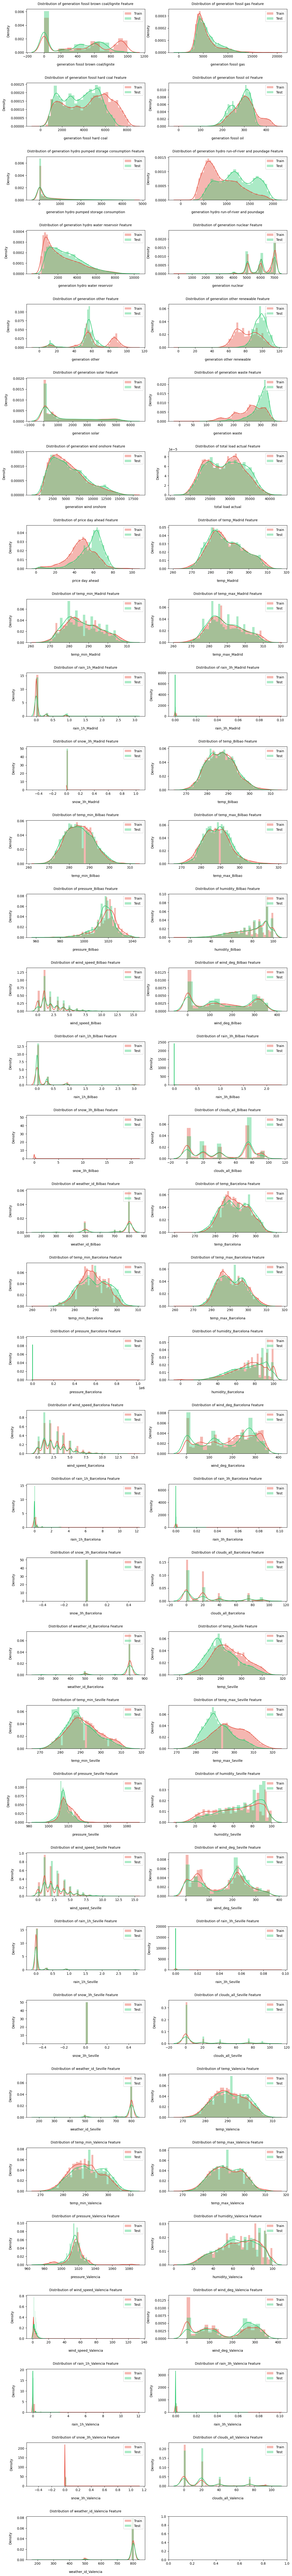

In [ ]:
#Get only float and int columns

cont_features=list(train_all.select_dtypes(include='float' or 'int').columns)
cont_features.remove("price actual")

get_numeric_features_plot(train_all,test_all,cont_features=cont_features,height=4,figsize=10, hspace=.7)

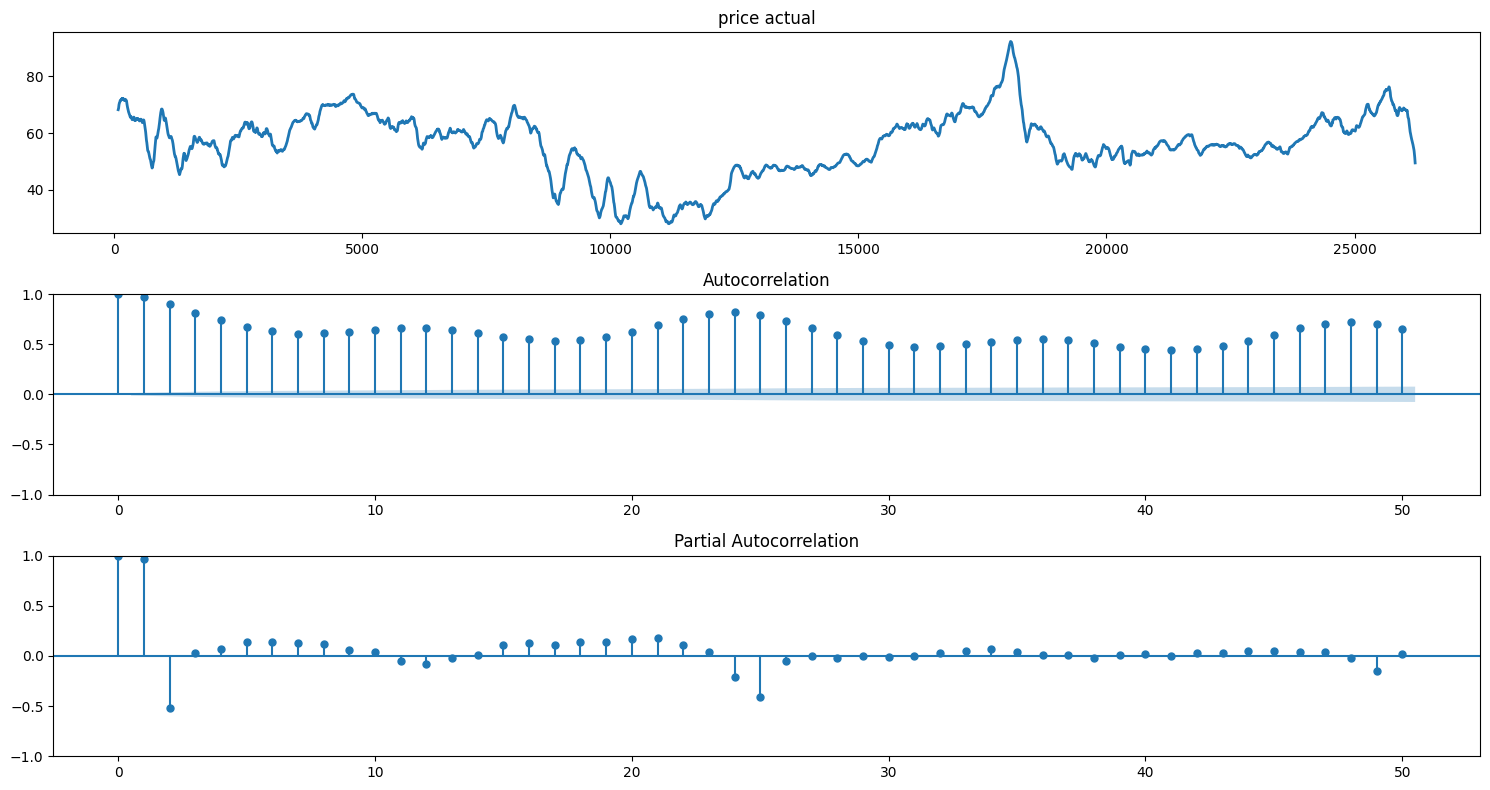

In [29]:
#Autocorrelation (3 yeasrs 2015-2017)

rolling = train_all['price actual'].rolling(24*7, center=True).mean()


fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(15, 8))
ax1.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
ax1.set_title("price actual")
plot_acf(train_all['price actual'], lags=50, ax=ax2)
plot_pacf(train_all['price actual'], lags=50, ax=ax3)

plt.tight_layout()
plt.show()

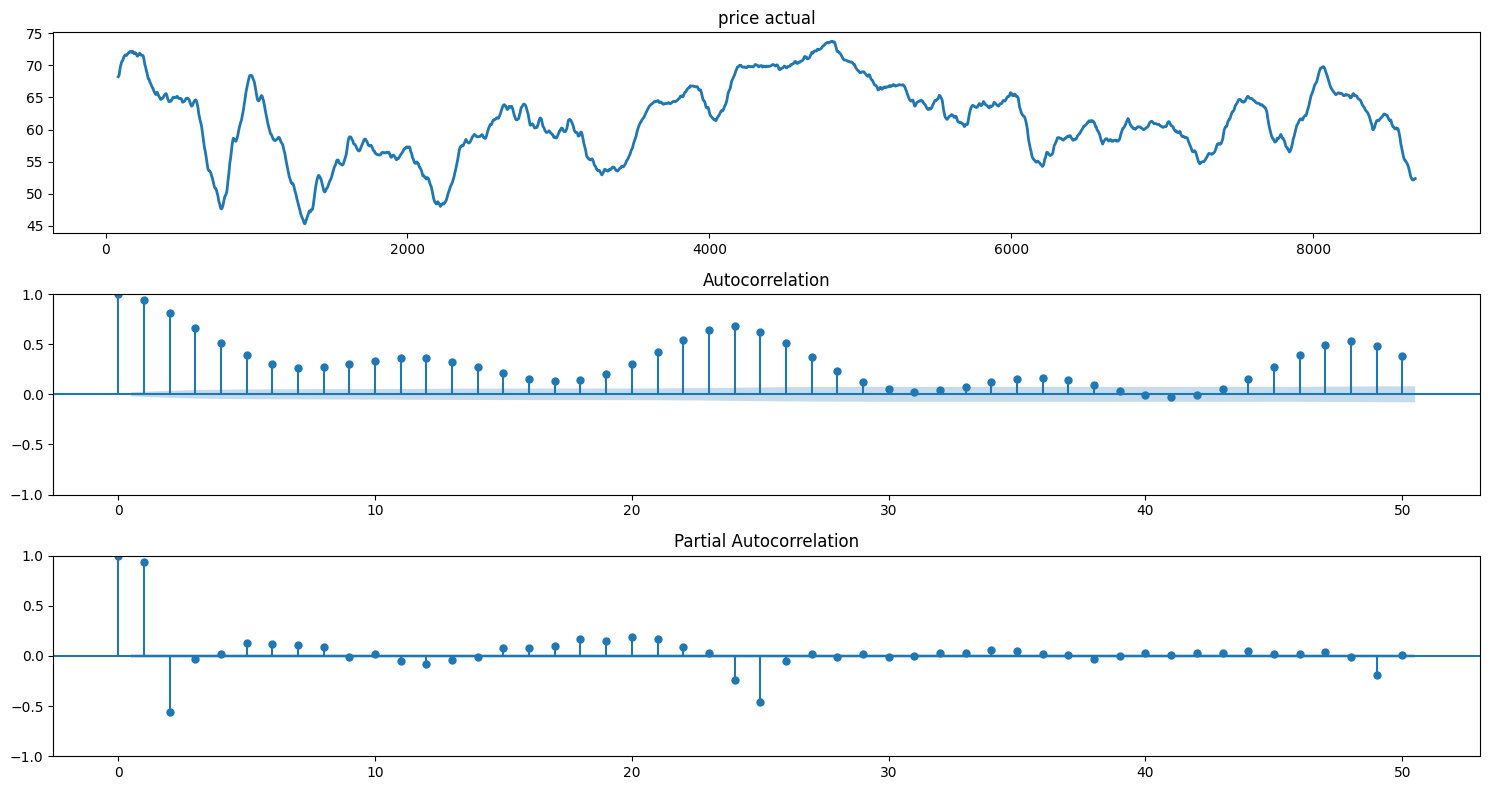

In [30]:
#Autocorrelation (1 year 2015)

train_2015=train_all.iloc[:8760,:]

rolling = train_2015['price actual'].rolling(24*7, center=True).mean()


fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(15, 8))
ax1.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
ax1.set_title("price actual")
plot_acf(train_2015['price actual'], lags=50, ax=ax2)
plot_pacf(train_2015['price actual'], lags=50, ax=ax3)

plt.tight_layout()
plt.show()

In [31]:
# Find the correlations between the electricity price and the rest of the features

correlations = train_all.corr(method='pearson')
highly_correlated = abs(correlations[correlations > 0.7])
print(highly_correlated[highly_correlated < 1.0].stack())

generation fossil brown coal/lignite  generation fossil hard coal             0.785257
generation fossil hard coal           generation fossil brown coal/lignite    0.785257
                                      price day ahead                         0.775842
price day ahead                       generation fossil hard coal             0.775842
                                      price actual                            0.726695
                                                                                ...   
temp_max_Valencia                     temp_max_Barcelona                      0.737980
                                      temp_Seville                            0.769823
                                      temp_min_Seville                        0.748979
                                      temp_Valencia                           0.986323
                                      temp_min_Valencia                       0.944885
Length: 92, dtype: float64


# 4. Feature Engineering


In [32]:
#Parameters
class CONFIG:
    lag=168
    fold=2
    depth=3

# 4.1 Time Features

In [33]:
## Make Time features by sin/cos

def make_time(input_df):
    
    output_df=pd.DataFrame()
    output_df["time"]=input_df["time"]

    output_df["month"]=output_df["time"].apply(lambda x: x.month)
    output_df["day"]=output_df["time"].apply(lambda x: x.day)
    output_df["year"]=output_df["time"].apply(lambda x: x.year)

    #Monthyly trend by Day
    output_df["month_sin"] = np.sin(output_df["day"] /31*np.pi * 2)
    output_df["month_cos"] = np.cos(output_df["day"] /31* np.pi * 2 )

    #Yearly trend by Month
    output_df["year_sin"] = np.sin(output_df["month"] /12 * np.pi * 2 )
    output_df["year_cos"] = np.cos(output_df["month"] /12 * np.pi * 2 )

    #Quater trend by month
    output_df["quater_sin"] = np.sin(output_df["month"] /4 * np.pi * 2 )
    output_df["quater_cos"] = np.cos(output_df["month"] /4 * np.pi * 2 )

    #Half Yearly trend by Month
    output_df["half_sin"] = np.sin(output_df["month"] /6 * np.pi * 2 )
    output_df["half_cos"] = np.cos(output_df["month"] /6 * np.pi * 2 )

    #2 Month Trend by Month
    output_df["2month_sin"] = np.sin(output_df["month"] /2 * np.pi * 2 )
    output_df["2month_cos"] = np.cos(output_df["month"] /2 * np.pi * 2 )
    
    output_df=output_df.drop(columns=["time"])

    return output_df

## 4.2 Make Lag Feature

In [34]:
def make_lag(input_df):

    #Select only highly correlated columns for lag features
    targets=list(highly_correlated[highly_correlated < 1.0].dropna(how="all").index)
    targets.remove("price actual")
    
    #1 day
    #shift_time=args.lag
    shift_time=CONFIG.lag

    output_df=input_df[targets].copy()

    for target in targets:
        for i in range(shift_time):
            output_df[target+f"_lag{i+1}"] = output_df[target].shift(i+1)
    
    output_df=output_df.fillna(0)
    output_df=output_df.iloc[:,len(targets):]

    return output_df

## 4.3 Encoding

In [35]:
def label_encoding(input_df):

    target_cols=list(input_df.select_dtypes(include='object').columns)
    features = input_df[target_cols]
    encoder = ce.OrdinalEncoder().fit(features.values)
    output_df = pd.DataFrame(encoder.transform(features.values))
    output_df.columns = target_cols
    output_df = output_df.add_prefix("LE_")
    output_df=output_df.astype(str)

    output_df = pd.concat([input_df, output_df], axis=1)
    output_df=output_df.iloc[:,-len(target_cols):]
 
    return output_df

def count_encoding(input_df):

    target_cols=list(input_df.select_dtypes(include='object').columns)
    features = input_df[target_cols]
    encoder = ce.CountEncoder().fit(features.values)
    output_df = pd.DataFrame(encoder.transform(features.values))
    output_df.columns = target_cols
    output_df = output_df.add_prefix("CE_")

    output_df = pd.concat([input_df, output_df], axis=1)
    output_df=output_df.iloc[:,-len(target_cols):]

    return output_df


def target_encoding(input_df):

    target_cols=list(input_df.select_dtypes(include='object').columns)
    features = input_df[target_cols]
    target=input_df["price actual"]
    encoder = ce.TargetEncoder().fit(features.values, target)
    output_df = pd.DataFrame(encoder.transform(features.values))
    output_df.columns = target_cols
    output_df = output_df.add_prefix("TE_")

    output_df = pd.concat([input_df, output_df], axis=1)
    output_df=output_df.iloc[:,-len(target_cols):]

    return output_df

## 4.4 Apply Feature Engineering to Dataset

In [36]:
def preprocess(train, test):
        input_df = pd.concat([train, test]).reset_index(drop=True)
        funcs = [make_time,
                label_encoding,
                count_encoding,
                target_encoding,
                make_lag]

        output = []
        for func in tqdm.tqdm(funcs):
                _df = func(input_df)
                output.append(_df)
        output = pd.concat(output, axis=1)
        output = pd.concat([input_df,output], axis=1)

        # output=standard_scaler(output)
        # output=select_features(output)
        drop_cols=list(input_df.select_dtypes(include='object').columns)
        output=output.drop(columns=drop_cols)
        
        

        train_x = output.iloc[:len(train)]
        test_x = output.iloc[len(train):].reset_index(drop=True)
        test_x=test_x.drop(columns=["price actual"])

        return train_x, test_x

In [37]:
train_x, test_x=preprocess(train_all,test_all)

Streaming output truncated to the last 5000 lines.
<ipython-input-34-815404a9e05d>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[target+f"_lag{i+1}"] = output_df[target].shift(i+1)
<ipython-input-34-815404a9e05d>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  output_df[target+f"_lag{i+1}"] = output_df[target].shift(i+1)
<ipython-input-34-815404a9e05d>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

In [38]:
train_x.head()

,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual,temp_Madrid,temp_min_Madrid,temp_max_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,rain_3h_Madrid,...,temp_max_Valencia_lag144,temp_max_Valencia_lag145,temp_max_Valencia_lag146,temp_max_Valencia_lag147,temp_max_Valencia_lag148,temp_max_Valencia_lag149,temp_max_Valencia_lag150,temp_max_Valencia_lag151,temp_max_Valencia_lag152,temp_max_Valencia_lag153,temp_max_Valencia_lag154,temp_max_Valencia_lag155,temp_max_Valencia_lag156,temp_max_Valencia_lag157,temp_max_Valencia_lag158,temp_max_Valencia_lag159,temp_max_Valencia_lag160,temp_max_Valencia_lag161,temp_max_Valencia_lag162,temp_max_Valencia_lag163,temp_max_Valencia_lag164,temp_max_Valencia_lag165,temp_max_Valencia_lag166,temp_max_Valencia_lag167,temp_max_Valencia_lag168
0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,25385.0,50.10,65.41,267.325,267.325,267.325,971,63,1,309,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24382.0,48.10,64.92,267.325,267.325,267.325,971,63,1,309,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,22734.0,47.33,64.48,266.186,266.186,266.186,971,64,1,273,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,21286.0,42.27,59.32,266.186,266.186,266.186,971,64,1,273,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,20264.0,38.41,56.04,266.186,266.186,266.186,971,64,1,273,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
test_x.head()

,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,temp_Madrid,temp_min_Madrid,temp_max_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,rain_3h_Madrid,snow_3h_Madrid,...,temp_max_Valencia_lag144,temp_max_Valencia_lag145,temp_max_Valencia_lag146,temp_max_Valencia_lag147,temp_max_Valencia_lag148,temp_max_Valencia_lag149,temp_max_Valencia_lag150,temp_max_Valencia_lag151,temp_max_Valencia_lag152,temp_max_Valencia_lag153,temp_max_Valencia_lag154,temp_max_Valencia_lag155,temp_max_Valencia_lag156,temp_max_Valencia_lag157,temp_max_Valencia_lag158,temp_max_Valencia_lag159,temp_max_Valencia_lag160,temp_max_Valencia_lag161,temp_max_Valencia_lag162,temp_max_Valencia_lag163,temp_max_Valencia_lag164,temp_max_Valencia_lag165,temp_max_Valencia_lag166,temp_max_Valencia_lag167,temp_max_Valencia_lag168
0,0.0,3471.0,996.0,194.0,2094.0,1076.0,1162.0,7057.0,52.0,79.0,9.0,237.0,12348.0,22779.0,6.74,282.12,280.15,284.15,1018,84,4,290,0.0,0.0,0.0,...,283.15,284.15,282.15,283.15,283.15,285.15,286.15,287.15,287.15,287.15,288.15,286.15,284.15,280.15,276.15,274.15,275.15,275.15,276.15,276.15,277.15,276.15,277.15,278.15,278.15
1,0.0,3269.0,959.0,191.0,2115.0,1046.0,799.0,7057.0,51.0,77.0,9.0,238.0,11156.0,22009.0,4.74,281.54,280.15,282.15,1019,87,3,280,0.0,0.0,0.0,...,283.15,283.15,284.15,282.15,283.15,283.15,285.15,286.15,287.15,287.15,287.15,288.15,286.15,284.15,280.15,276.15,274.15,275.15,275.15,276.15,276.15,277.15,276.15,277.15,278.15
2,0.0,3541.0,1014.0,191.0,2037.0,1048.0,898.0,7058.0,51.0,79.0,9.0,236.0,9437.0,20589.0,3.66,279.14,277.15,281.15,1020,87,4,280,0.0,0.0,0.0,...,284.15,283.15,283.15,284.15,282.15,283.15,283.15,285.15,286.15,287.15,287.15,287.15,288.15,286.15,284.15,280.15,276.15,274.15,275.15,275.15,276.15,276.15,277.15,276.15,277.15
3,0.0,3450.0,1043.0,191.0,2126.0,1021.0,714.0,7061.0,52.0,79.0,9.0,238.0,6474.0,19547.0,2.30,278.11,276.15,280.15,1021,87,1,290,0.0,0.0,0.0,...,286.15,284.15,283.15,283.15,284.15,282.15,283.15,283.15,285.15,286.15,287.15,287.15,287.15,288.15,286.15,284.15,280.15,276.15,274.15,275.15,275.15,276.15,276.15,277.15,276.15
4,0.0,3318.0,1063.0,191.0,2580.0,1033.0,661.0,7066.0,51.0,79.0,9.0,239.0,6329.0,18871.0,2.30,277.59,276.15,279.15,1021,87,2,290,0.0,0.0,0.0,...,285.15,286.15,284.15,283.15,283.15,284.15,282.15,283.15,283.15,285.15,286.15,287.15,287.15,287.15,288.15,286.15,284.15,280.15,276.15,274.15,275.15,275.15,276.15,276.15,277.15


# 5. Model Development

In [40]:
#Get Categorical features
cat_col=list(train_x.select_dtypes(include='object').columns)
train_x[cat_col]=train_x[cat_col].astype(int)
test_x[cat_col]=test_x[cat_col].astype(int)

#Get Columns for Predict 
pred_col = list(train_x.columns)
pred_col.remove("price actual")

In [41]:
#Model Preparation
class SingleLgb:
    def __init__(self, cat_col, seed=71, dry_run=False):
        self.train_param = self.get_param(seed)
        if dry_run:
            self.num_rounds = 2000
        else:
            self.num_rounds = 10000

        self.cat_col=cat_col

    def do_train_direct(self, x_train, x_test, y_train, y_test):
        lgb_train = lgb.Dataset(x_train, y_train)
        lgb_eval = lgb.Dataset(x_test, y_test)

        print('Start training...')
        model = lgb.train(self.train_param,
                          lgb_train,
                          valid_sets=[lgb_eval],
                          verbose_eval=100,
                          num_boost_round=self.num_rounds,
                          early_stopping_rounds=100,
                          categorical_feature=self.cat_col
                         )
        print('End training...')

        return model
    
    @staticmethod
    def show_feature_importance(model, filename=None):
        fi = pd.DataFrame({
            "name": model.feature_name(),
            "importance_split": model.feature_importance(importance_type="split").astype(int),
            "importance_gain": model.feature_importance(importance_type="gain").astype(int),
        })
        fi = fi.sort_values(by="importance_gain", ascending=False)
        print(fi)

            
    @staticmethod
    def get_param(seed=71):
        return {
            'num_leaves': 1023,
            'min_data_in_leaf': 50,
            'objective': 'regression',
            'metric': 'rmse',
            'max_depth': CONFIG.depth,
            'learning_rate': 0.05,
            "boosting": "gbdt",
            "feature_fraction": 0.9,
            "verbosity": -1,
            "random_state": seed,
        }
    
class SingleTrainer:
    def __init__(self, pred_col, cat_col,dry_run=False):
        self.pred_col = pred_col
        self.target_col = 'price actual'
        self.dry_run = dry_run
        self.cat_col=cat_col


    def train_model(self, df):
        X = df[self.pred_col]
        y = df[self.target_col]
        kf = TimeSeriesSplit(n_splits=CONFIG.fold)

        models, scores = list(), list()
        for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
            print("---------")
            print("fold=", fold)

            X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
            print(X_train.shape, X_val.shape)

            lgbm = SingleLgb(seed=71, dry_run=self.dry_run, cat_col=self.cat_col)
            model = lgbm.do_train_direct(X_train, X_val, y_train, y_val)
            y_pred=model.predict(X_val)
            score=np.sqrt(mean_squared_error(y_val,y_pred))
            if fold == 0:                
                lgbm.show_feature_importance(model)
            models.append(model)
            scores.append(score)
            print(f'fold= {fold} RMSE Score='+str(score))
 
        return models, np.mean(scores)

# 6. Training

In [42]:
trainer = SingleTrainer(pred_col, cat_col=cat_col,dry_run=False)
models, score = trainer.train_model(train_x)
print(score)

---------
fold= 0
(8768, 3160) (8768, 3160)
Start training...
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.17461
[200]	valid_0's rmse: 1.04648
[300]	valid_0's rmse: 1.02996
[400]	valid_0's rmse: 1.02257
[500]	valid_0's rmse: 1.02021
Early stopping, best iteration is:
[459]	valid_0's rmse: 1.0187
End training...
                          name  importance_split  importance_gain
120                    TE_time               898         13180375
14             price_day_ahead               279           424628
78                   month_sin                21            33048
84                    half_sin                33            19531
76                         day                37            10303
...                        ...               ...              ...
1167         temp_Bilbao_lag24                 0                0
1168         temp_Bilbao_lag25                 0                0
1169         temp_Bilbao_lag26                 0    

In [43]:
preds_train = []
for m in models:
    preds_train.append(m.predict(train_x[pred_col]))

pred_train = np.mean(preds_train, axis=0)
 #모델들의 평균을 취한다

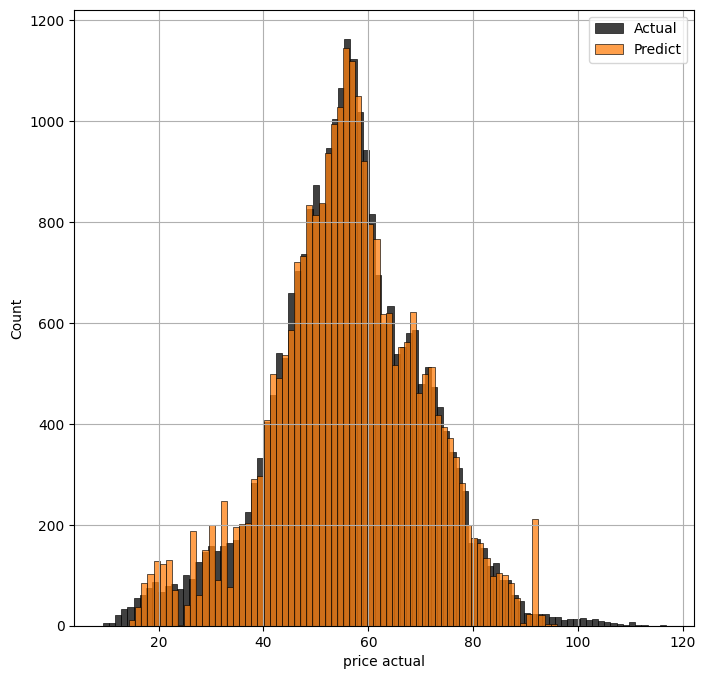

In [44]:
# Distributiuon of Train Data
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(train_x["price actual"], label='Actual', ax=ax, color='black')
sns.histplot(pred_train, label='Predict', ax=ax, color='C1')
ax.legend()
ax.grid()

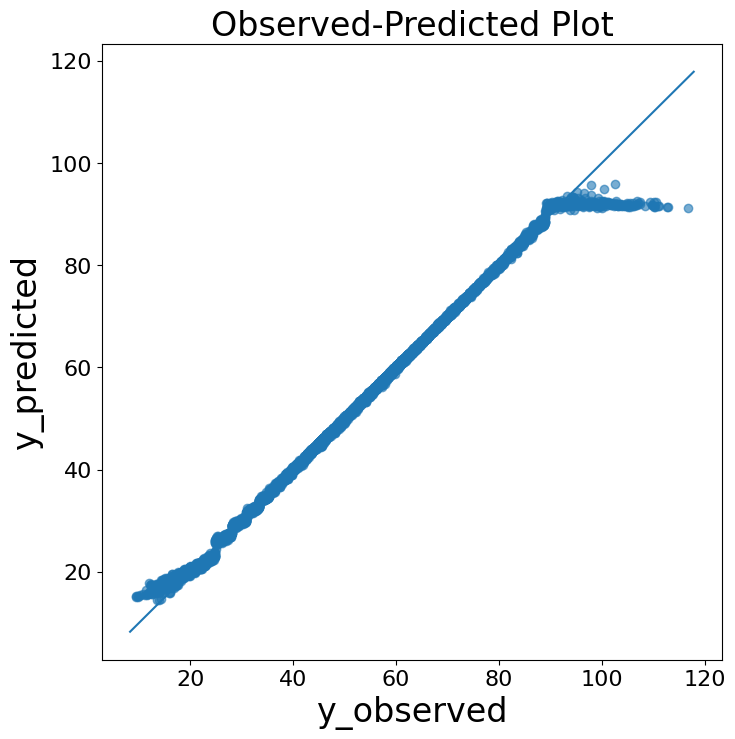

In [47]:
#yy-plot
def yy_plot(y_obs, y_pred):
    yvalues = np.concatenate([y_obs, y_pred])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    plt.figure(figsize=(8, 8))
    plt.scatter(y_obs, y_pred,alpha=.6)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    #plt.xlim(10, 17)
    #plt.ylim(10,17)
    plt.xlabel('y_observed', fontsize=24)
    plt.ylabel('y_predicted', fontsize=24)
    plt.title('Observed-Predicted Plot', fontsize=24)
    plt.tick_params(labelsize=16)

yy_plot(y_obs=train_x["price actual"].values,y_pred=pred_train)

# 7. Inference

In [48]:
preds = []
for m in models:
    preds.append(m.predict(test_x[pred_col]))

In [49]:
pred = np.mean(preds, axis=0)
sub_df["predicted"]=pred

In [50]:
sub_df

,id,predicted
0,0,16.642312
1,1,16.253813
2,2,16.226720
3,3,16.136155
4,4,16.113422
...,...,...
8755,8755,19.063867
8756,8756,19.048736
8757,8757,19.067877
8758,8758,19.046172


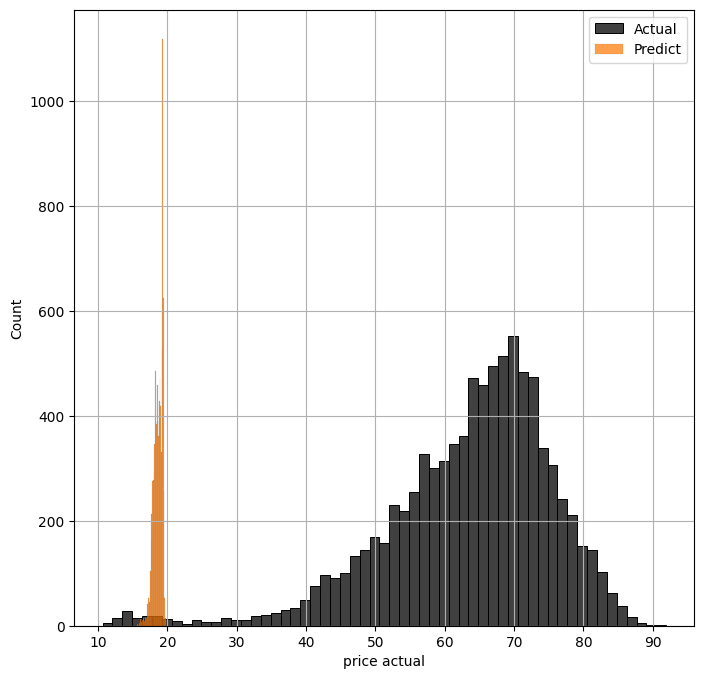

In [52]:
# Distributiuon of Test Data
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(test_price, label='Actual', ax=ax, color='black')
sns.histplot(sub_df["predicted"], label='Predict', ax=ax, color='C1')
ax.legend()
ax.grid()